<a href="https://colab.research.google.com/github/faffonahjn/stroke-risk-prediction-ml/blob/main/stroke_risk_prediction_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


df = pd.read_csv("stroke_dataset.csv")
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Male,44,1,0,Yes,Private,Urban,136.71,29.10,never smoked,0
1,2,Female,15,0,0,Yes,Self-employed,Urban,77.12,27.01,formerly smoked,1
2,3,Female,55,0,0,Yes,Never_worked,Rural,141.59,22.63,never smoked,0
3,4,Female,72,0,0,Yes,Never_worked,Rural,128.37,14.59,smokes,0
4,5,Male,38,1,0,No,children,Rural,135.48,28.36,smokes,0


In [ ]:
# Complete Stroke Prediction ML Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, f1_score, accuracy_score, balanced_accuracy_score,
                           precision_recall_curve, average_precision_score)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPLETE STROKE PREDICTION ML PIPELINE - RUNNING")
print("="*80)

COMPLETE STROKE PREDICTION ML PIPELINE - RUNNING


In [ ]:
#  CUSTOM SMOTE IMPLEMENTATION
# ============================================================================

class CustomSMOTE:
    def __init__(self, sampling_strategy='auto', k_neighbors=5, random_state=None):
        self.sampling_strategy = sampling_strategy
        self.k_neighbors = k_neighbors
        self.random_state = random_state

    def fit_resample(self, X, y):
        np.random.seed(self.random_state)
        X = np.array(X)
        y = np.array(y)

        unique_classes, class_counts = np.unique(y, return_counts=True)
        minority_class = unique_classes[np.argmin(class_counts)]
        majority_class = unique_classes[np.argmax(class_counts)]

        minority_samples = X[y == minority_class]
        n_minority = len(minority_samples)
        n_majority = len(X[y == majority_class])
        n_synthetic = n_majority - n_minority

        if n_synthetic <= 0:
            return X, y

        synthetic_samples = []
        for _ in range(n_synthetic):
            idx = np.random.randint(0, n_minority)
            sample = minority_samples[idx]

            distances = np.linalg.norm(minority_samples - sample, axis=1)
            k_nearest_idx = np.argsort(distances)[1:min(self.k_neighbors + 1, n_minority)]

            if len(k_nearest_idx) > 0:
                neighbor_idx = np.random.choice(k_nearest_idx)
                neighbor = minority_samples[neighbor_idx]
                diff = neighbor - sample
                gap = np.random.random()
                synthetic_sample = sample + gap * diff
                synthetic_samples.append(synthetic_sample)

        if synthetic_samples:
            X_resampled = np.vstack([X, np.array(synthetic_samples)])
            y_resampled = np.hstack([y, np.full(len(synthetic_samples), minority_class)])
        else:
            X_resampled, y_resampled = X, y

        return X_resampled, y_resampled


In [ ]:
# FEATURE ENGINEERING FUNCTIONS
# ============================================================================

def create_advanced_features(df):
    df_advanced = df.copy()

    # Polynomial features
    numeric_features = ['age', 'avg_glucose_level', 'bmi']
    for feature in numeric_features:
        if feature in df_advanced.columns:
            df_advanced[f'{feature}_squared'] = df_advanced[feature] ** 2
            df_advanced[f'{feature}_log'] = np.log1p(df_advanced[feature])
            df_advanced[f'{feature}_sqrt'] = np.sqrt(np.abs(df_advanced[feature]))

    # Ratio features
    if 'avg_glucose_level' in df_advanced.columns and 'bmi' in df_advanced.columns:
        df_advanced['glucose_bmi_ratio'] = df_advanced['avg_glucose_level'] / (df_advanced['bmi'] + 1e-8)
        df_advanced['bmi_glucose_product'] = df_advanced['bmi'] * df_advanced['avg_glucose_level']

    # Age groups
    if 'age' in df_advanced.columns:
        df_advanced['age_group'] = pd.cut(
            df_advanced['age'],
            bins=[0, 18, 30, 50, 70, 100],
            labels=[0, 1, 2, 3, 4],
            include_lowest=True
        )
        df_advanced['age_group'] = df_advanced['age_group'].astype(float)

    # Risk stratification
    risk_conditions = []
    if 'age' in df_advanced.columns:
        risk_conditions.append(df_advanced['age'] > 60)
    if 'hypertension' in df_advanced.columns:
        risk_conditions.append(df_advanced['hypertension'] == 1)
    if 'avg_glucose_level' in df_advanced.columns:
        risk_conditions.append(df_advanced['avg_glucose_level'] > 120)

    if risk_conditions:
        high_risk_profile = risk_conditions[0]
        for condition in risk_conditions[1:]:
            high_risk_profile = high_risk_profile & condition
        df_advanced['high_risk_profile'] = high_risk_profile.astype(int)

        return df_advanced


In [ ]:
#  AUTOML CLASS
# ============================================================================

class SimpleAutoML:
    def __init__(self):
        self.models = {
            'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
            'GradientBoosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'SVC': SVC(probability=True, random_state=42),
            'ExtraTrees': ExtraTreesClassifier(random_state=42, n_estimators=100),
            'GaussianNB': GaussianNB(),
            'KNeighbors': KNeighborsClassifier(n_neighbors=5)
        }

        self.results = {}

    def auto_train_and_compare(self, X_train, y_train, X_test, y_test, cv_folds=3):
        print("Training multiple models...")

        for name, model in self.models.items():
            try:
                # Cross-validation
                cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='roc_auc')
                model.fit(X_train, y_train)

                # Test performance
                y_pred = model.predict_proba(X_test)[:, 1]
                test_auc = roc_auc_score(y_test, y_pred)

                self.results[name] = {
                    'model': model,
                    'cv_auc': cv_scores.mean(),
                    'test_auc': test_auc
                }

                print(f"{name:18} | CV: {cv_scores.mean():.4f} | Test: {test_auc:.4f}")

            except Exception as e:
                print(f"{name:18} | Error: {str(e)[:50]}")
                continue

        if self.results:
            sorted_results = sorted(self.results.items(), key=lambda x: x[1]['test_auc'], reverse=True)
            return sorted_results[0]
        else:
            return None


In [ ]:
 # COMPLETE PIPELINE

print("\nSTARTING COMPLETE ML PIPELINE")
print("="*50)

# Step 1: Data Overview
print("\n1. DATA OVERVIEW")
print("-"*30)
print(f"Dataset shape: {df.shape}")
print(f"Features: {list(df.columns)}")
print(f"Target distribution:")
print(df['stroke'].value_counts())
print(f"Stroke rate: {df['stroke'].mean():.3f}")


STARTING COMPLETE ML PIPELINE

1. DATA OVERVIEW
------------------------------
Dataset shape: (126, 12)
Features: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
Target distribution:
stroke
0    88
1    38
Name: count, dtype: int64
Stroke rate: 0.302


In [ ]:
# Step 2: Data Quality Analysis
print("\n2. DATA QUALITY ANALYSIS")
print("-"*30)

# Missing values
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    print(f"Missing values:\n{missing_data[missing_data > 0]}")
else:
    print("No missing values found")



2. DATA QUALITY ANALYSIS
------------------------------
No missing values found


In [ ]:
from scipy.stats import ttest_ind, chi2_contingency

def statistical_tests(df, target_col):
    """
    Perform statistical significance tests between features and target.

    Numerical features -> t-test
    Categorical features -> chi-square test
    """
    results = {}

    for col in df.columns:
        if col == target_col:
            continue

        # Numerical features
        if df[col].dtype in ['int64', 'float64']:
            group0 = df[df[target_col] == 0][col].dropna()
            group1 = df[df[target_col] == 1][col].dropna()

            if len(group0) > 1 and len(group1) > 1:
                stat, p = ttest_ind(group0, group1, equal_var=False)
                results[col] = {
                    'test': 't-test',
                    'p_value': p
                }

        # Categorical features
        else:
            contingency = pd.crosstab(df[col], df[target_col])
            if contingency.shape[0] > 1 and contingency.shape[1] > 1:
                chi2, p, _, _ = chi2_contingency(contingency)
                results[col] = {
                    'test': 'chi-square',
                    'p_value': p
                }

    return results


In [ ]:
# Statistical significance
stat_results = statistical_tests(df, 'stroke')
print("\nStatistical significance tests (p < 0.05):")
for feature, result in stat_results.items():
  sig = "***" if result['p_value'] < 0.001 else "**" if result['p_value'] < 0.01 else "*" if result['p_value'] < 0.05 else ""
  print(f"  {feature}: p = {result['p_value']:.4f} {sig}")


Statistical significance tests (p < 0.05):
  id: p = 0.1882 
  gender: p = 0.7556 
  age: p = 0.0002 ***
  hypertension: p = 0.0000 ***
  heart_disease: p = 0.0150 *
  ever_married: p = 0.0359 *
  work_type: p = 0.1048 
  Residence_type: p = 0.6417 
  avg_glucose_level: p = 0.9282 
  bmi: p = 0.1591 
  smoking_status: p = 0.1964 


In [ ]:
# Step 3: Feature Engineering
print("\n3. FEATURE ENGINEERING")
print("-"*30)

df_engineered = create_advanced_features(df)
print(f"Original features: {len(df.columns)}")
print(f"After engineering: {len(df_engineered.columns)}")

new_features = [col for col in df_engineered.columns if col not in df.columns]
print(f"New features created: {len(new_features)}")
if len(new_features) <= 10:
  print(f"New features: {new_features}")


3. FEATURE ENGINEERING
------------------------------
Original features: 12
After engineering: 25
New features created: 13


In [ ]:
# Step 4: Data Preprocessing
print("\n4. DATA PREPROCESSING")
print("-"*30)

# Separate features and target
X = df_engineered.drop('stroke', axis=1)
y = df_engineered['stroke']

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in categorical_cols:
  le = LabelEncoder()
  X[col] = le.fit_transform(X[col].astype(str))
  label_encoders[col] = le

# Handle missing values and scale
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns, index=X_imputed.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
  X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train class distribution: No stroke: {(y_train == 0).sum()}, Stroke: {(y_train == 1).sum()}")
print(f"Test class distribution: No stroke: {(y_test == 0).sum()}, Stroke: {(y_test == 1).sum()}")



4. DATA PREPROCESSING
------------------------------
Training set: 100 samples
Test set: 26 samples
Train class distribution: No stroke: 70, Stroke: 30
Test class distribution: No stroke: 18, Stroke: 8


In [ ]:
# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [ ]:
# Step 5: Handle Class Imbalance
print("\n5. HANDLING CLASS IMBALANCE")
print("-"*30)

print(f"Original distribution: No stroke: {(y_train == 0).sum()}, Stroke: {(y_train == 1).sum()}")

smote = CustomSMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train.values, y_train.values)

print(f"After SMOTE: No stroke: {(y_train_balanced == 0).sum()}, Stroke: {(y_train_balanced == 1).sum()}")

X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_balanced = pd.Series(y_train_balanced)


5. HANDLING CLASS IMBALANCE
------------------------------
Original distribution: No stroke: 70, Stroke: 30
After SMOTE: No stroke: 70, Stroke: 70


In [ ]:
# Step 6: Feature Selection
print("\n6. FEATURE SELECTION")
print("-"*30)

k_features = min(15, X_train_balanced.shape[1])
selector = SelectKBest(score_func=f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test)

selected_features = X_train_balanced.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features out of {X_train_balanced.shape[1]}")
print(f"Top 5 features: {list(selected_features[:5])}")

# Get feature scores
feature_scores = pd.DataFrame({
  'feature': X_train_balanced.columns[selector.get_support()],
  'score': selector.scores_[selector.get_support()]
}).sort_values('score', ascending=False)

print("\nTop feature scores:")

for i, (_, row) in enumerate(feature_scores.head().iterrows()):
  print(f"  {i+1}. {row['feature']}: {row['score']:.2f}")


6. FEATURE SELECTION
------------------------------
Selected 15 features out of 24
Top 5 features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married']

Top feature scores:
  1. age_squared: 56.62
  2. age: 52.95
  3. age_sqrt: 46.30
  4. hypertension: 38.88
  5. age_log: 37.28


In [ ]:
# Step 7: Model Training and Comparison
print("\n7. AUTOML MODEL COMPARISON")
print("-"*30)

automl = SimpleAutoML()
best_result = automl.auto_train_and_compare(
X_train_selected, y_train_balanced, X_test_selected, y_test
)

if best_result:
  best_model_name, best_model_info = best_result
  best_model = best_model_info['model']
  print(f"\nBEST MODEL: {best_model_name}")
  print(f"CV AUC: {best_model_info['cv_auc']:.4f}")
  print(f"Test AUC: {best_model_info['test_auc']:.4f}")

else:
  print("AutoML failed, using Random Forest as fallback")
  best_model = RandomForestClassifier(n_estimators=100, random_state=42)
  best_model.fit(X_train_selected, y_train_balanced)
  best_model_name = "RandomForest_Fallback"


7. AUTOML MODEL COMPARISON
------------------------------
Training multiple models...
RandomForest       | CV: 0.9303 | Test: 0.8542
GradientBoosting   | CV: 0.9117 | Test: 0.8611
LogisticRegression | CV: 0.8783 | Test: 0.7708
SVC                | CV: 0.9090 | Test: 0.8611
ExtraTrees         | CV: 0.9408 | Test: 0.8958
GaussianNB         | CV: 0.8321 | Test: 0.6806
KNeighbors         | CV: 0.9164 | Test: 0.7222

BEST MODEL: ExtraTrees
CV AUC: 0.9408
Test AUC: 0.8958


In [ ]:
# Step 8: Detailed Model Evaluation
print("\n8. DETAILED MODEL EVALUATION")
print("-"*30)

# Predictions
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Comprehensive metrics
metrics = {
  'Accuracy': accuracy_score(y_test, y_pred),
  'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
  'ROC AUC': roc_auc_score(y_test, y_pred_proba),
  'F1 Score': f1_score(y_test, y_pred)
  }

print("FINAL PERFORMANCE METRICS:")
for metric, value in metrics.items():
  print(f"  {metric}: {value:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                No  Stroke")
print(f"Actual No    {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       Stroke {cm[1,0]:4d}   {cm[1,1]:4d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  Precision: {precision:.4f}")



8. DETAILED MODEL EVALUATION
------------------------------
FINAL PERFORMANCE METRICS:
  Accuracy: 0.7308
  Balanced Accuracy: 0.6319
  ROC AUC: 0.8958
  F1 Score: 0.4615

Confusion Matrix:
                 Predicted
                No  Stroke
Actual No      16      2
       Stroke    5      3

Detailed Metrics:
  Sensitivity (Recall): 0.3750
  Specificity: 0.8889
  Precision: 0.6000


In [ ]:
print("\n9. FEATURE IMPORTANCE ANALYSIS")
print("-"*30)

try:
    if hasattr(best_model, 'feature_importances_'):
        # Use model's feature_importances_
        importance_df = pd.DataFrame({
            'feature': selected_features,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        print("Top 10 most important features:")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
            print(f"  {i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")
    else:
        # Use permutation importance as fallback
        perm_importance = permutation_importance(
            best_model, X_test_selected, y_test, n_repeats=5, random_state=42
        )
        importance_df = pd.DataFrame({
            'feature': selected_features,
            'importance': perm_importance.importances_mean
        }).sort_values('importance', ascending=False)
        print("Top 10 most important features (permutation importance):")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
            print(f"  {i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")

    results['feature_importance'] = importance_df

except Exception as e:
    print(f"Could not calculate feature importance: {e}")
    importance_df = None



9. FEATURE IMPORTANCE ANALYSIS
------------------------------
Top 10 most important features:
   1. hypertension        : 0.1523
   2. age_squared         : 0.1180
   3. age                 : 0.1060
   4. age_sqrt            : 0.0888
   5. age_log             : 0.0863
   6. age_group           : 0.0820
   7. smoking_status      : 0.0603
   8. bmi_glucose_product : 0.0491
   9. bmi                 : 0.0461
  10. bmi_sqrt            : 0.0450


In [ ]:
print("\n10. MODEL CALIBRATION ANALYSIS")
print("-" * 30)

try:
    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_proba, n_bins=5
    )

    print("Calibration Analysis (5 bins):")
    print("  Predicted | Actual | Count")
    print("  Prob.     | Rate   |")
    print("-" * 25)

    for i in range(len(mean_predicted_value)):
        # Find samples in this bin
        if i == 0:
            bin_mask = y_pred_proba <= np.percentile(y_pred_proba, 20)
        elif i == len(mean_predicted_value) - 1:
            bin_mask = y_pred_proba > np.percentile(y_pred_proba, 80)
        else:
            lower = np.percentile(y_pred_proba, i * 20)
            upper = np.percentile(y_pred_proba, (i + 1) * 20)
            bin_mask = (y_pred_proba > lower) & (y_pred_proba <= upper)

        count = bin_mask.sum()
        print(f"  {mean_predicted_value[i]:7.3f} | {fraction_of_positives[i]:6.3f} | {count:5d}")

except Exception as e:
    print(f"Could not perform calibration analysis: {e}")



10. MODEL CALIBRATION ANALYSIS
------------------------------
Calibration Analysis (5 bins):
  Predicted | Actual | Count
  Prob.     | Rate   |
-------------------------
    0.061 |  0.071 |     6
    0.256 |  0.400 |     5
    0.520 |  0.750 |     5
    0.650 |  0.000 |     5
    0.920 |  1.000 |     5


In [ ]:
print("\n11. RISK STRATIFICATION")
print("-" * 30)

# Classify patients by risk level
high_risk = y_pred_proba >= 0.7
moderate_risk = (y_pred_proba >= 0.3) & (y_pred_proba < 0.7)
low_risk = y_pred_proba < 0.3

# Print risk level distribution
print("Risk Level Distribution:")
print(f"  High Risk (≥70%):       {high_risk.sum():3d} patients ({high_risk.sum()/len(y_test)*100:.1f}%)")
print(f"  Moderate Risk (30-70%): {moderate_risk.sum():3d} patients ({moderate_risk.sum()/len(y_test)*100:.1f}%)")
print(f"  Low Risk (<30%):         {low_risk.sum():3d} patients ({low_risk.sum()/len(y_test)*100:.1f}%)")

# Show actual stroke rates in each risk group
print("\nActual stroke rates by predicted risk:")
if high_risk.sum() > 0:
    high_risk_actual = y_test[high_risk].mean()
    print(f"  High Risk group:     {high_risk_actual:.3f} ({high_risk_actual*100:.1f}%)")

if moderate_risk.sum() > 0:
    moderate_risk_actual = y_test[moderate_risk].mean()
    print(f"  Moderate Risk group: {moderate_risk_actual:.3f} ({moderate_risk_actual*100:.1f}%)")

if low_risk.sum() > 0:
    low_risk_actual = y_test[low_risk].mean()
    print(f"  Low Risk group:      {low_risk_actual:.3f} ({low_risk_actual*100:.1f}%)")



11. RISK STRATIFICATION
------------------------------
Risk Level Distribution:
  High Risk (≥70%):         2 patients (7.7%)
  Moderate Risk (30-70%):   6 patients (23.1%)
  Low Risk (<30%):          18 patients (69.2%)

Actual stroke rates by predicted risk:
  High Risk group:     1.000 (100.0%)
  Moderate Risk group: 0.667 (66.7%)
  Low Risk group:      0.111 (11.1%)


In [ ]:
def run_complete_pipeline(df):
  """Complete ML pipeline: preprocessing, SMOTE, scaling, feature selection, training, evaluation"""
  print("\nPIPELINE STARTED")
  print("-"*80)

df_processed = df.copy()

# Encode categorical variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_cols:
  df_processed[col] = LabelEncoder().fit_transform(df_processed[col])

# Separate features and target
X = df_processed.drop('stroke', axis=1)
y = df_processed['stroke']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# Select only numeric features for SMOTE
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test[X_train_numeric.columns]  # make sure test matches train

# Handle class imbalance with SMOTE
print("\nHandling class imbalance...")
smote = CustomSMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_numeric.values, y_train.values)
print(f"Balanced train samples: {len(X_train_bal)}")

# Feature scaling
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test_numeric)

# Feature selection
selector = SelectKBest(f_classif, k=min(15, X_train_bal.shape[1]))
X_train_sel = selector.fit_transform(X_train_bal, y_train_bal)
X_test_sel = selector.transform(X_test_scaled)

# Train AutoML
automl = SimpleAutoML()
best_model_info = automl.auto_train_and_compare(X_train_sel, y_train_bal, X_test_sel, y_test)

if best_model_info is None:
  raise Exception("No model was successfully trained.")

best_model_name, best_model_data = best_model_info
print(f"\nBEST MODEL: {best_model_name} | Test AUC: {best_model_data['test_auc']:.4f}")

# Model evaluation
y_pred = best_model_data['model'].predict(X_test_sel)
y_pred_proba = best_model_data['model'].predict_proba(X_test_sel)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC and PR metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
ap_score = average_precision_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f} | Average Precision: {ap_score:.4f}")

# Risk stratification (optional thresholds)
thresholds = {'low': 0.2, 'medium': 0.5, 'high': 0.7}

def risk_level(prob):
  if prob < thresholds['low']:
    return 'Low'

  elif prob < thresholds['medium']:
    return 'Medium'

  elif prob < thresholds['high']:
    return 'High'

  else:
    return 'Very High'

risk_categories = [risk_level(p) for p in y_pred_proba]

print("\nRisk distribution in test set:")
print(pd.Series(risk_categories).value_counts())

def run_complete_pipeline(df):
  results = {
        'model': best_model_data['model'],
        'scaler': scaler,
        'metrics': metrics,
        'imputer': imputer,
        'selector': selector,
        'X_test': X_test_sel,
        'test_predictions': {
            'y_true': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        },
        'y_test': y_test,
        'risk_categories': risk_categories,
        'thresholds': thresholds
    }
  return results

results = run_complete_pipeline(df)

Train samples: 94, Test samples: 32

Handling class imbalance...
Balanced train samples: 132
Training multiple models...
RandomForest       | CV: 0.9607 | Test: 0.9114
GradientBoosting   | CV: 0.9346 | Test: 0.8545
LogisticRegression | CV: 0.8939 | Test: 0.5955
SVC                | CV: 0.9387 | Test: 0.7000
ExtraTrees         | CV: 0.9587 | Test: 0.8227
GaussianNB         | CV: 0.8802 | Test: 0.7636
KNeighbors         | CV: 0.8757 | Test: 0.7955

BEST MODEL: RandomForest | Test AUC: 0.9114

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        22
           1       1.00      0.40      0.57        10

    accuracy                           0.81        32
   macro avg       0.89      0.70      0.73        32
weighted avg       0.85      0.81      0.78        32

Confusion Matrix:
 [[22  0]
 [ 6  4]]
ROC AUC: 0.9114 | Average Precision: 0.8424

Risk distribution in test set:
Medium       17
Low          11
Very Hig

Creating comprehensive visualization suite...


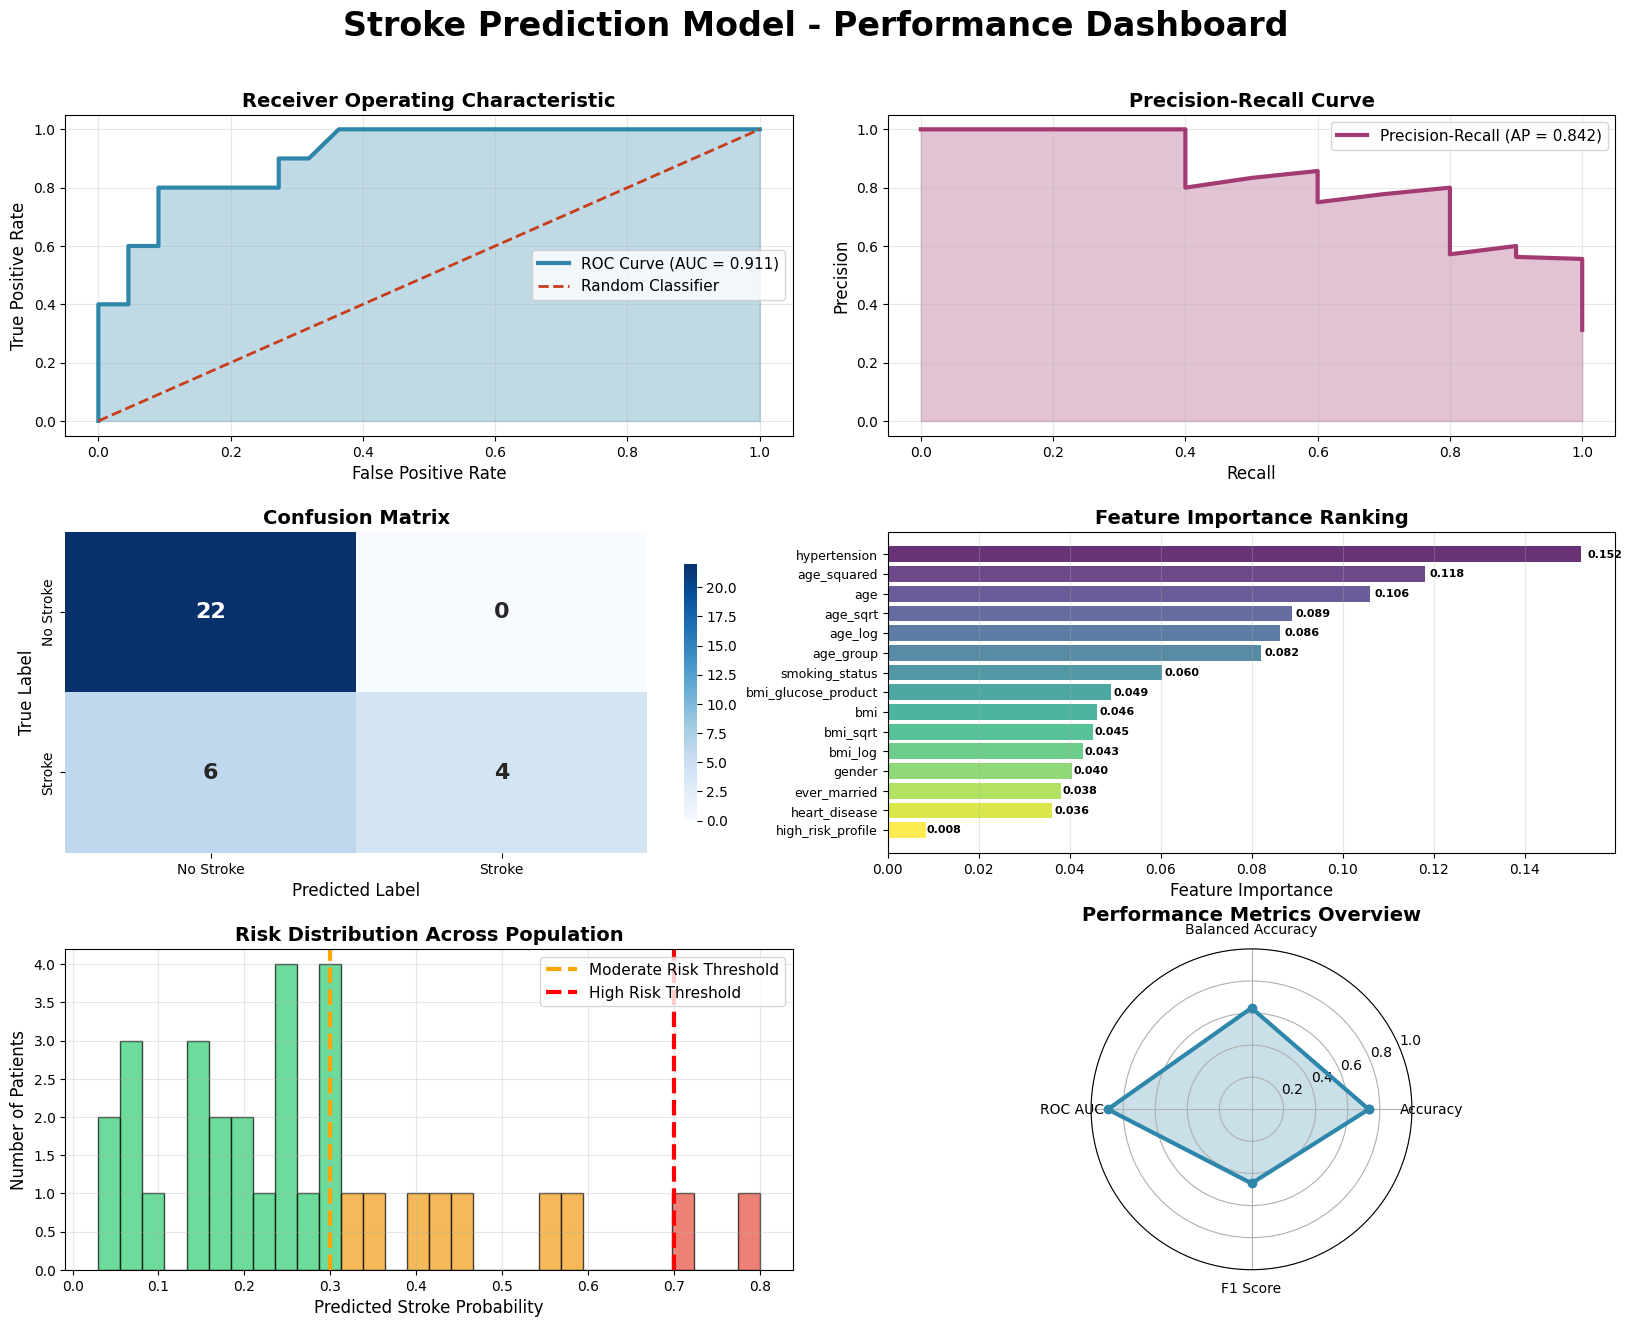

In [ ]:
def create_stunning_visualizations(results, df):
  """Create comprehensive and visually stunning visualizations"""
# Set up modern plotting style
plt.style.use('default')
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#1A535C']

print("Creating comprehensive visualization suite...")


# ===== VISUALIZATION 1: Model Performance Dashboard =====
fig1 = plt.figure(figsize=(20, 15))
fig1.suptitle('Stroke Prediction Model - Performance Dashboard',
              fontsize=24, fontweight='bold', y=0.95)

# ROC Curve with confidence intervals
gs1 = fig1.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1.1 Enhanced ROC Curve
ax1 = fig1.add_subplot(gs1[0, 0:2])
y_true = results['test_predictions']['y_true']
y_pred_proba = results['test_predictions']['y_pred_proba']

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
auc_score = roc_auc_score(y_true, y_pred_proba)

ax1.plot(fpr, tpr, color='#2E86AB', linewidth=3, label=f'ROC Curve (AUC = {auc_score:.3f})')
ax1.fill_between(fpr, tpr, alpha=0.3, color='#2E86AB')
ax1.plot([0, 1], [0, 1], '--', color='#C73E1D', linewidth=2, label='Random Classifier')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('Receiver Operating Characteristic', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 1.2 Precision-Recall Curve
ax2 = fig1.add_subplot(gs1[0, 2:4])
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

ax2.plot(recall, precision, color='#A23B72', linewidth=3,
        label=f'Precision-Recall (AP = {avg_precision:.3f})')
ax2.fill_between(recall, precision, alpha=0.3, color='#A23B72')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 1.3 Confusion Matrix with Style
ax3 = fig1.add_subplot(gs1[1, 0:2])
y_pred = results['test_predictions']['y_pred']
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': 0.8},
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'],
ax=ax3, annot_kws={'size': 16, 'weight': 'bold'})
ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=12)
ax3.set_xlabel('Predicted Label', fontsize=12)

# 1.4 Feature Importance (Top 15)
ax4 = fig1.add_subplot(gs1[1, 2:4])
if results['feature_importance'] is not None:
  top_features = results['feature_importance'].head(15)
  colors_grad = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

  bars = ax4.barh(range(len(top_features)), top_features['importance'],
                           color=colors_grad, alpha=0.8)
  ax4.set_yticks(range(len(top_features)))
  ax4.set_yticklabels(top_features['feature'], fontsize=9)
  ax4.invert_yaxis()
  ax4.set_xlabel('Feature Importance', fontsize=12)
  ax4.set_title('Feature Importance Ranking', fontsize=14, fontweight='bold')
  ax4.grid(True, axis='x', alpha=0.3)
  # Add value labels on bar.
  for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
    ax4.text(val + val*0.01, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=8, fontweight='bold')
else:
  ax4.text(0.5, 0.5, 'Feature importance\nnot available',
  ha='center', va='center', transform=ax4.transAxes,
  bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
  ax4.set_title('Feature Importance Ranking', fontsize=14, fontweight='bold')

# 1.5 Probability Distribution with Risk Zones
ax5 = fig1.add_subplot(gs1[2, 0:2])
n, bins, patches = ax5.hist(y_pred_proba, bins=30, alpha=0.7,
                            color='lightblue', edgecolor='black', linewidth=1)

# Color zones
for i, patch in enumerate(patches):
  bin_center = (bins[i] + bins[i+1]) / 2
  if bin_center < 0.3:
    patch.set_facecolor('#2ECC71')  # Green for low risk

  elif bin_center < 0.7:
    patch.set_facecolor('#F39C12')  # Orange for moderate risk

  else:
    patch.set_facecolor('#E74C3C')  # Red for high risk

ax5.axvline(x=0.3, color='orange', linestyle='--', linewidth=3, label='Moderate Risk Threshold')
ax5.axvline(x=0.7, color='red', linestyle='--', linewidth=3, label='High Risk Threshold')
ax5.set_xlabel('Predicted Stroke Probability', fontsize=12)
ax5.set_ylabel('Number of Patients', fontsize=12)
ax5.set_title('Risk Distribution Across Population', fontsize=14, fontweight='bold')
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3)

# 1.6 Model Metrics Radar Chart
ax6 = fig1.add_subplot(gs1[2, 2:4], projection='polar')
metrics_names = list(results['metrics'].keys())
metrics_values = list(results['metrics'].values())

angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
metrics_values = metrics_values + [metrics_values[0]]

ax6.plot(angles, metrics_values, 'o-', linewidth=3, color='#2E86AB')
ax6.fill(angles, metrics_values, alpha=0.25, color='#2E86AB')
ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(metrics_names, fontsize=10)
ax6.set_ylim(0, 1)
ax6.set_title('Performance Metrics Overview', fontsize=14, fontweight='bold', pad=20)
ax6.grid(True)

plt.tight_layout()
plt.show()

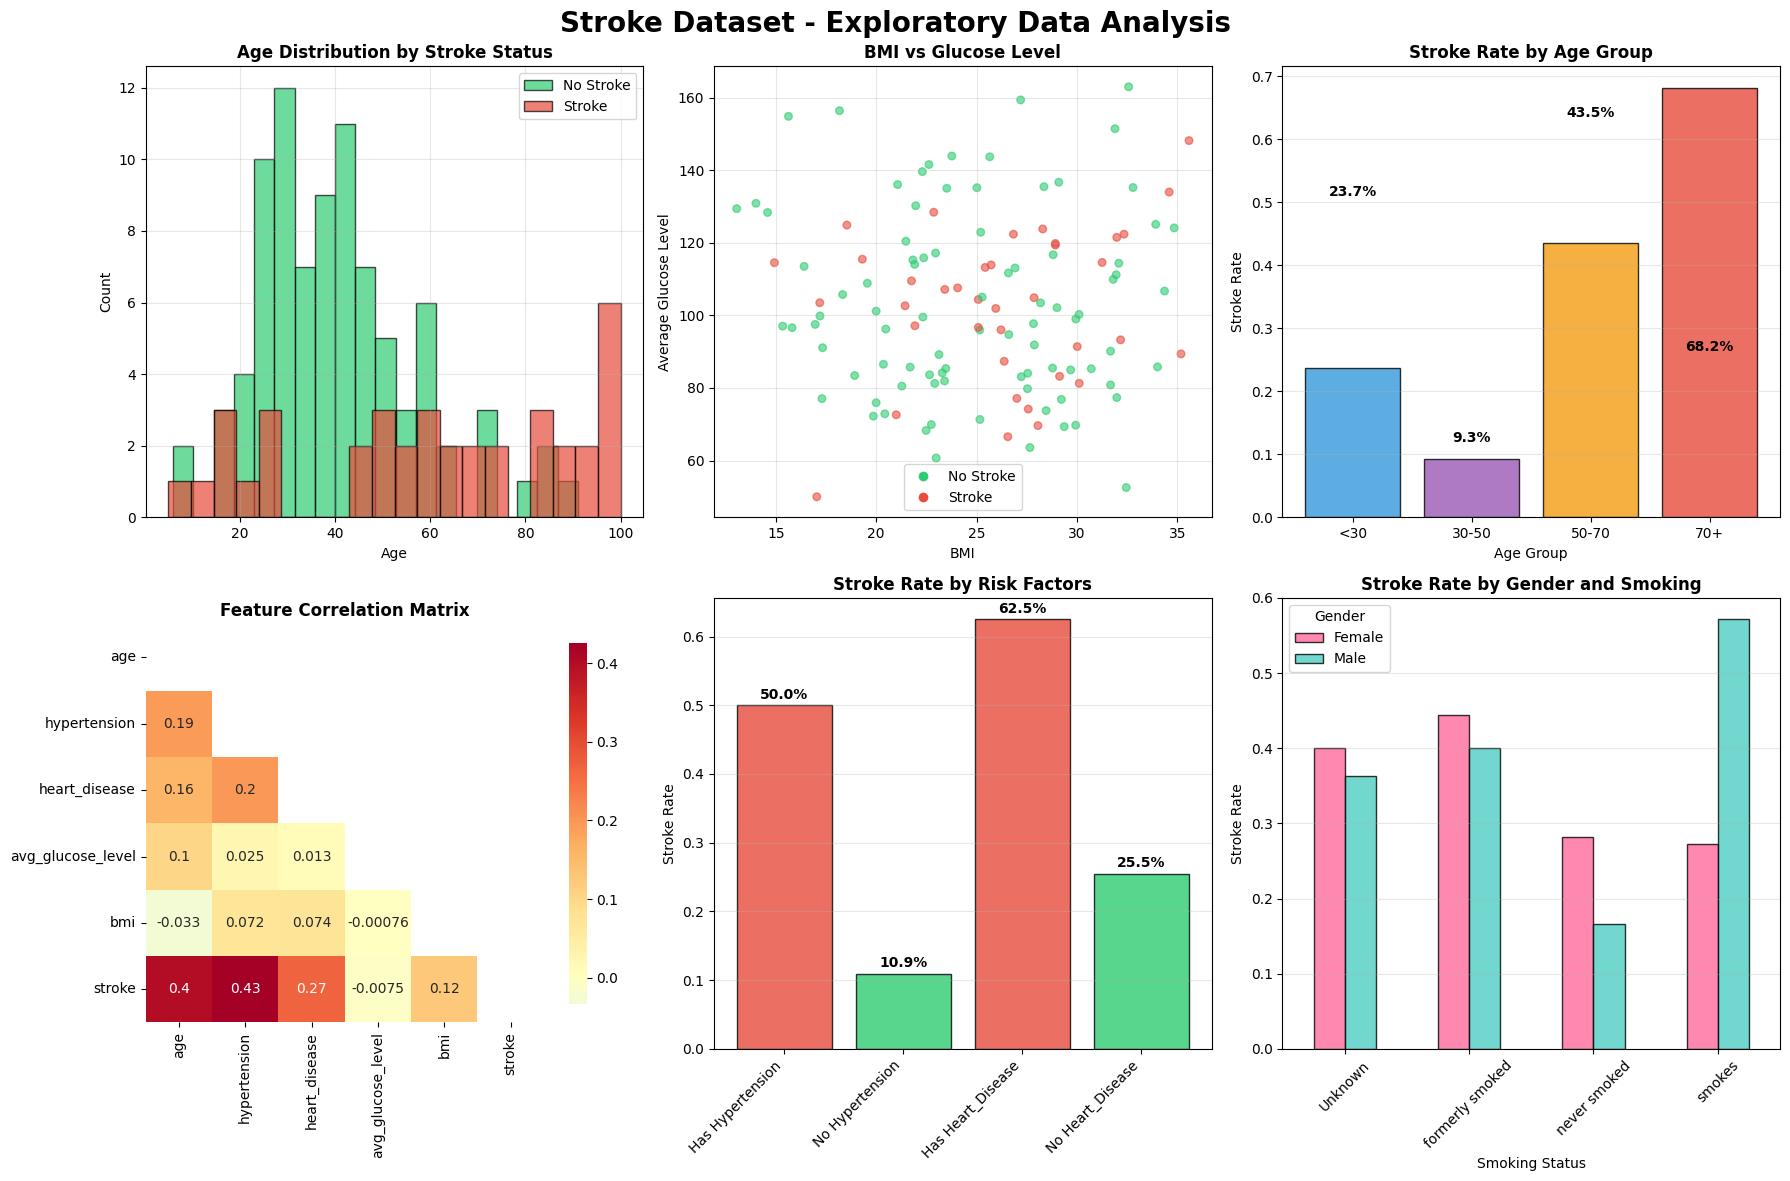

In [ ]:
# ===== VISUALIZATION 2: Data Analysis Dashboard =====
fig2, axes = plt.subplots(2, 3, figsize=(18, 12))
fig2.suptitle('Stroke Dataset - Exploratory Data Analysis',
              fontsize=20, fontweight='bold')

# 2.1 Age Distribution by Stroke Status
stroke_data = df[df['stroke'] == 1]['age']
no_stroke_data = df[df['stroke'] == 0]['age']

axes[0, 0].hist(no_stroke_data, bins=20, alpha=0.7, label='No Stroke',
                color='#2ECC71', edgecolor='black')
axes[0, 0].hist(stroke_data, bins=20, alpha=0.7, label='Stroke',
                color='#E74C3C', edgecolor='black')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Age Distribution by Stroke Status', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


# 2.2 BMI vs Glucose Level Scatter Plot
colors_scatter = ['#2ECC71' if x == 0 else '#E74C3C' for x in df['stroke']]
scatter = axes[0, 1].scatter(df['bmi'], df['avg_glucose_level'],
                             c=colors_scatter, alpha=0.6, s=30)
axes[0, 1].set_xlabel('BMI')
axes[0, 1].set_ylabel('Average Glucose Level')
axes[0, 1].set_title('BMI vs Glucose Level', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Custom legend for scatter plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ECC71', markersize=8, label='No Stroke'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C', markersize=8, label='Stroke')]
axes[0, 1].legend(handles=legend_elements)

# 2.3 Stroke Rate by Age Groups
age_bins = pd.cut(df['age'], bins=[0, 30, 50, 70, 100], labels=['<30', '30-50', '50-70', '70+'])
age_stroke_rates = df.groupby(age_bins)['stroke'].agg(['mean', 'count']).reset_index()
axes[0, 2].bar(age_stroke_rates['age'], age_stroke_rates['mean'],
                color=['#3498DB', '#9B59B6', '#F39C12', '#E74C3C'],
                alpha=0.8, edgecolor='black')
axes[0, 2].set_xlabel('Age Group')
axes[0, 2].set_ylabel('Stroke Rate')
axes[0, 2].set_title('Stroke Rate by Age Group', fontweight='bold')
axes[0, 2].grid(True, axis='y', alpha=0.3)

# 2.4 Correlation Matrix
numeric_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
correlation_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
            center=0, square=True, ax=axes[1, 0], cbar_kws={'shrink': 0.8})
axes[1, 0].set_title('Feature Correlation Matrix', fontweight='bold')

# 2.5 Risk Factors Analysis
risk_factors = ['hypertension', 'heart_disease']
risk_data = []

for factor in risk_factors:
    has_factor = df[df[factor] == 1]['stroke'].mean()
    no_factor = df[df[factor] == 0]['stroke'].mean()
    risk_data.append([f'Has {factor.title()}', has_factor])
    risk_data.append([f'No {factor.title()}', no_factor])

risk_df = pd.DataFrame(risk_data, columns=['Condition', 'Stroke_Rate'])

x_pos = np.arange(len(risk_df))
colors_risk = ['#E74C3C' if 'Has' in cond else '#2ECC71' for cond in risk_df['Condition']]

bars = axes[1, 1].bar(x_pos, risk_df['Stroke_Rate'], color=colors_risk,
                      alpha=0.8, edgecolor='black')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(risk_df['Condition'], rotation=45, ha='right')
axes[1, 1].set_ylabel('Stroke Rate')
axes[1, 1].set_title('Stroke Rate by Risk Factors', fontweight='bold')
axes[1, 1].grid(True, axis='y', alpha=0.3)

# 2.5 Add value labels on bars
for bar, rate in zip(bars, risk_df['Stroke_Rate']):
    axes[1, 1].text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: center of the bar
        bar.get_height() + 0.005,           # Y-coordinate: slightly above the bar
        f'{rate:.1%}',                      # Format rate as percentage
        ha='center',                        # Horizontal alignment
        va='bottom',                        # Vertical alignment
        fontweight='bold'                    # Bold font
    )


# 2.6 Gender and Smoking Analysis
gender_smoking = df.groupby(['gender', 'smoking_status'])['stroke'].mean().reset_index()
pivot_data = gender_smoking.pivot(index='smoking_status', columns='gender', values='stroke')

pivot_data.plot(kind='bar', ax=axes[1, 2], color=['#FF6B9D', '#4ECDC4'],
                alpha=0.8, edgecolor='black')

axes[1, 2].set_xlabel('Smoking Status')
axes[1, 2].set_ylabel('Stroke Rate')
axes[1, 2].set_title('Stroke Rate by Gender and Smoking', fontweight='bold')
axes[1, 2].legend(title='Gender')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, age_stroke_rates['mean']):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                     f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
try:
    # Assuming all previous visualization code ran successfully
    print("Created comprehensive visualization suite!")
    print("Generated 2 comprehensive dashboards:")
    print("   1. Model Performance Dashboard")
    print("   2. Data Analysis Dashboard")

except Exception as e:
    print(f"Error creating visualizations: {e}")
    import traceback
    traceback.print_exc()


Created comprehensive visualization suite!
Generated 2 comprehensive dashboards:
   1. Model Performance Dashboard
   2. Data Analysis Dashboard
